In [1]:
import os 

print(os.getcwd())

import KITTI_dataset_s
from KITTI_dataset_s import getSavePath, parse_args, SatGrdDatasetTest
import utils 
from models_kitti import Model
# from dataLoader.KITTI_dataset import SatGrdDatasetTest
import matplotlib.gridspec as gridspec


import torch
from torch.utils.data import DataLoader
import numpy as np 
from matplotlib import pyplot as plt
from math import sin, cos

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

np.random.seed(2022)

args = parse_args()

save_path = getSavePath(args)
net = Model(args)
net.to(device)

net.load_state_dict(torch.load(os.path.join(save_path, 'model_4.pth')), strict=False)


c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\Boosting3DoFAccuracy\spyridonidis


c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


save_path: ./ModelsKitti/3DoF/lat20.0m_lon20.0m_rot10.0_Nit2_TransV1G2SP_CrossAttn_Uncertainty


c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

tensor([-35.2893], device='cuda:0') tensor([-98.5882], device='cuda:0') tensor([-0.0774], device='cuda:0')
tensor(-40.8690, device='cuda:0') tensor(-97.0553, device='cuda:0') tensor(0.3786, device='cuda:0')


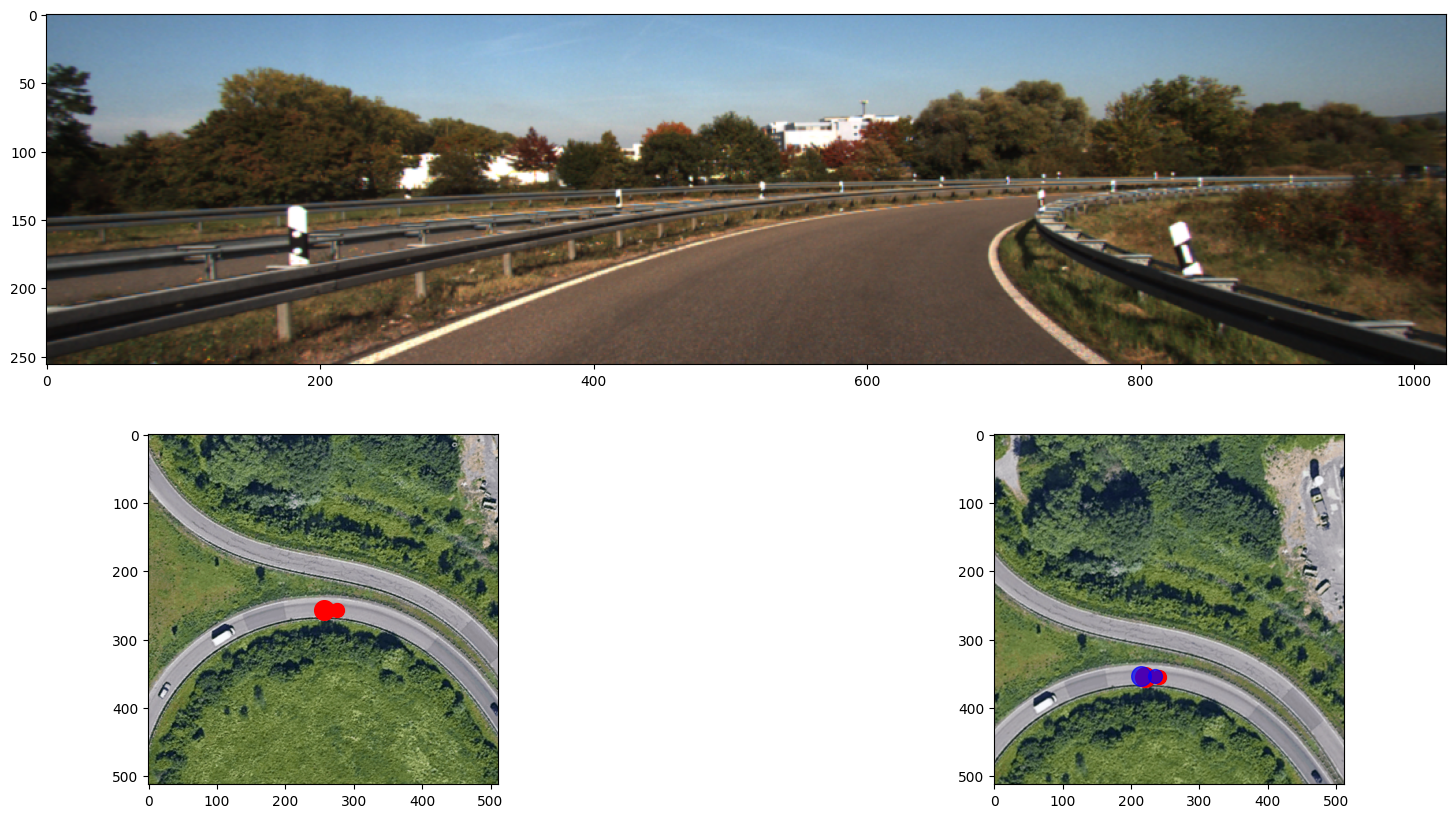

tensor([38.1873], device='cuda:0') tensor([36.9914], device='cuda:0') tensor([-7.5242], device='cuda:0')
tensor(23.6434, device='cuda:0') tensor(42.4616, device='cuda:0') tensor(-7.3371, device='cuda:0')


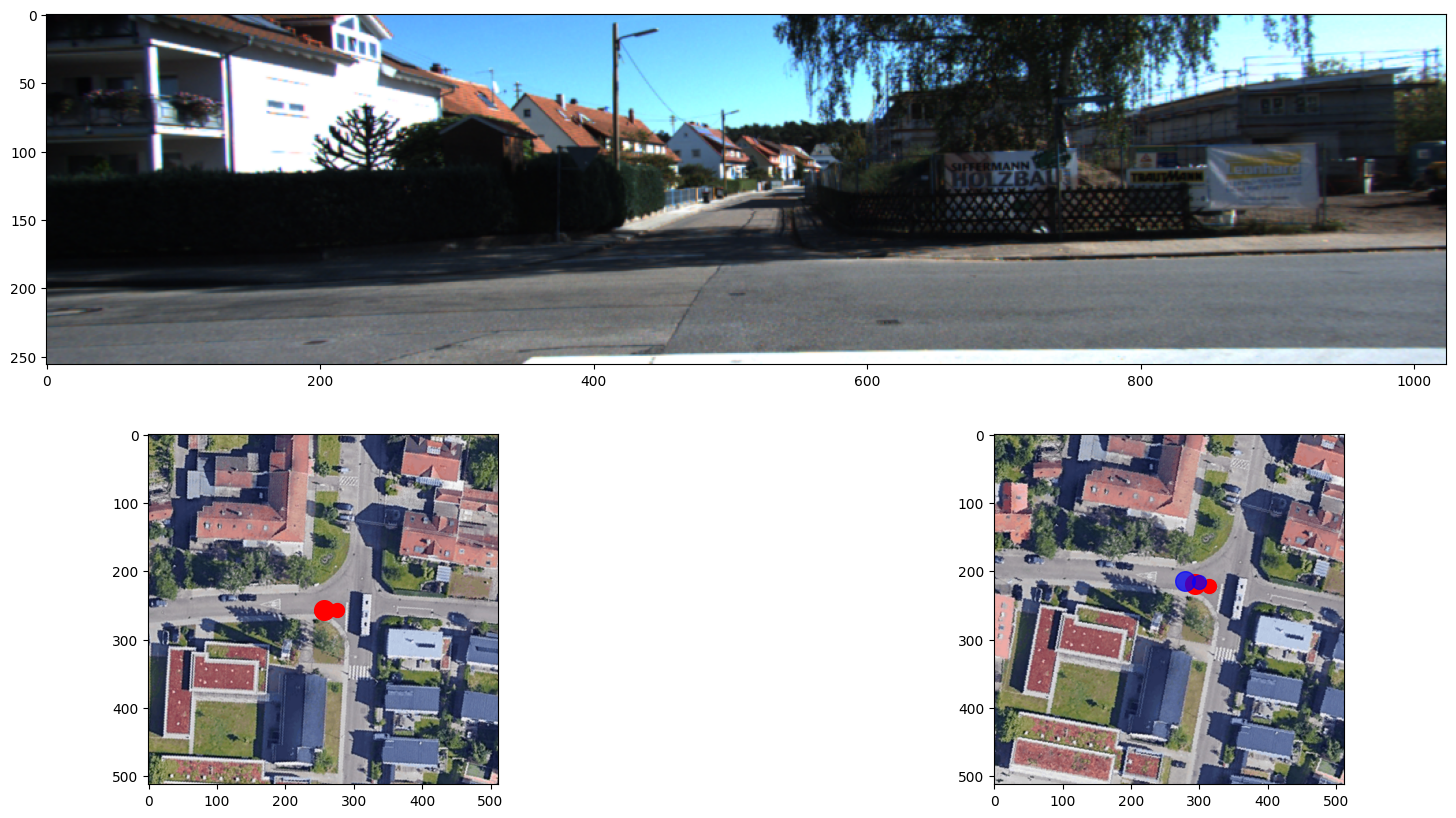

tensor([95.3784], device='cuda:0') tensor([43.3431], device='cuda:0') tensor([9.5674], device='cuda:0')
tensor(93.6239, device='cuda:0') tensor(44.0518, device='cuda:0') tensor(8.8821, device='cuda:0')


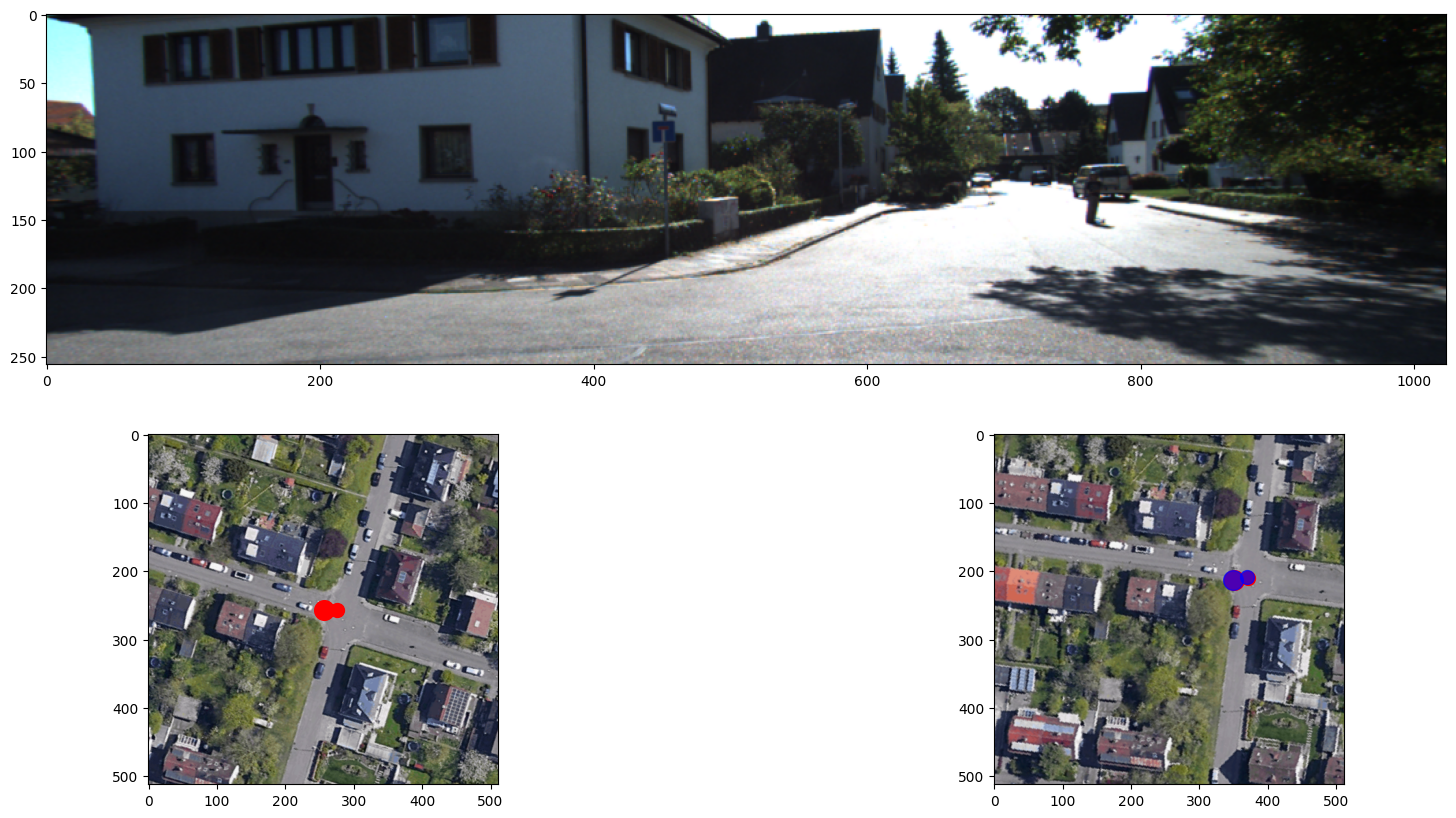

tensor([-6.1969], device='cuda:0') tensor([82.4454], device='cuda:0') tensor([-2.8357], device='cuda:0')
tensor(-9.1989, device='cuda:0') tensor(84.6486, device='cuda:0') tensor(-2.6117, device='cuda:0')


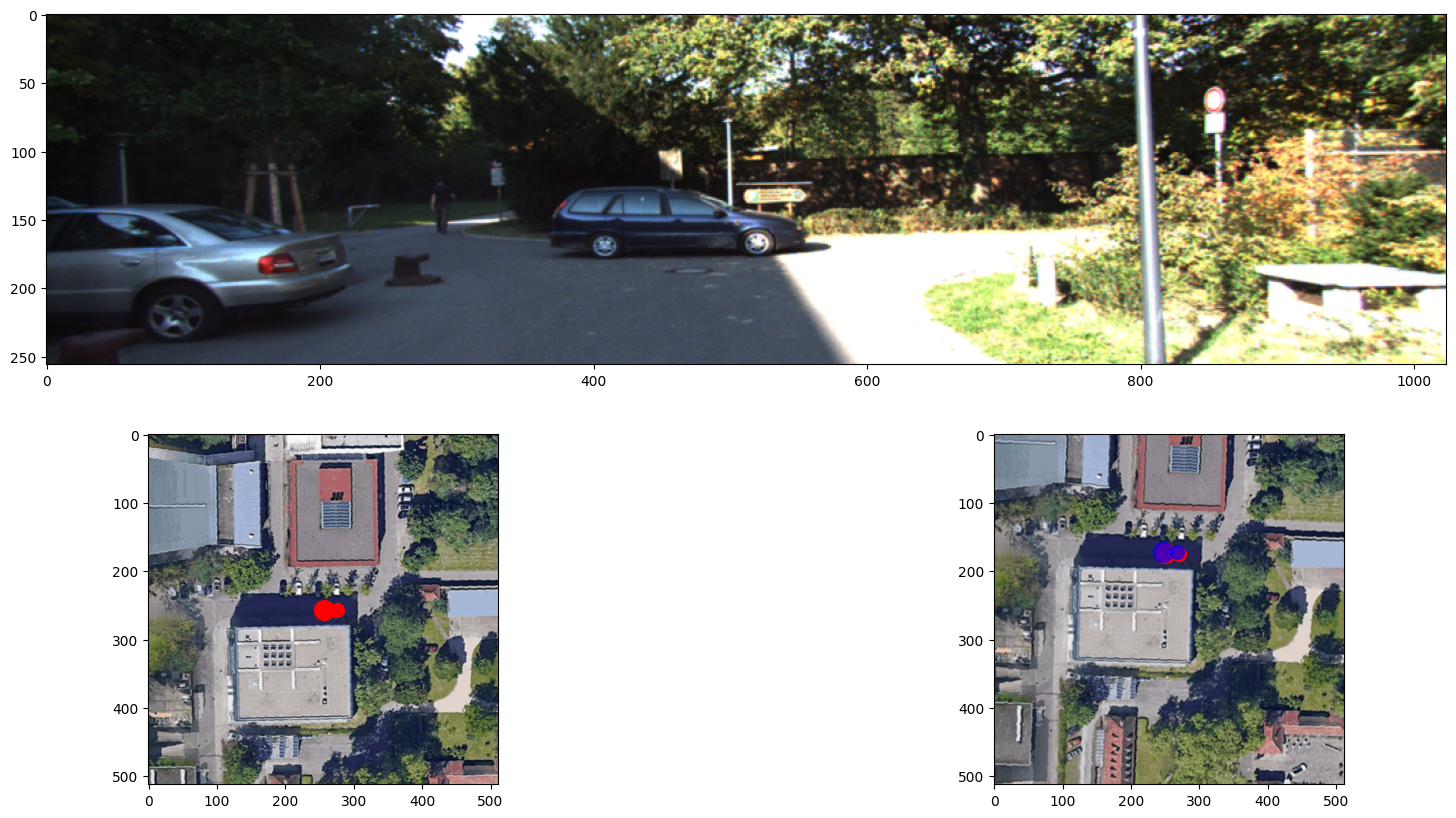

tensor([-90.8316], device='cuda:0') tensor([-101.4331], device='cuda:0') tensor([-2.2312], device='cuda:0')
tensor(-65.3271, device='cuda:0') tensor(-95.6157, device='cuda:0') tensor(-1.7654, device='cuda:0')


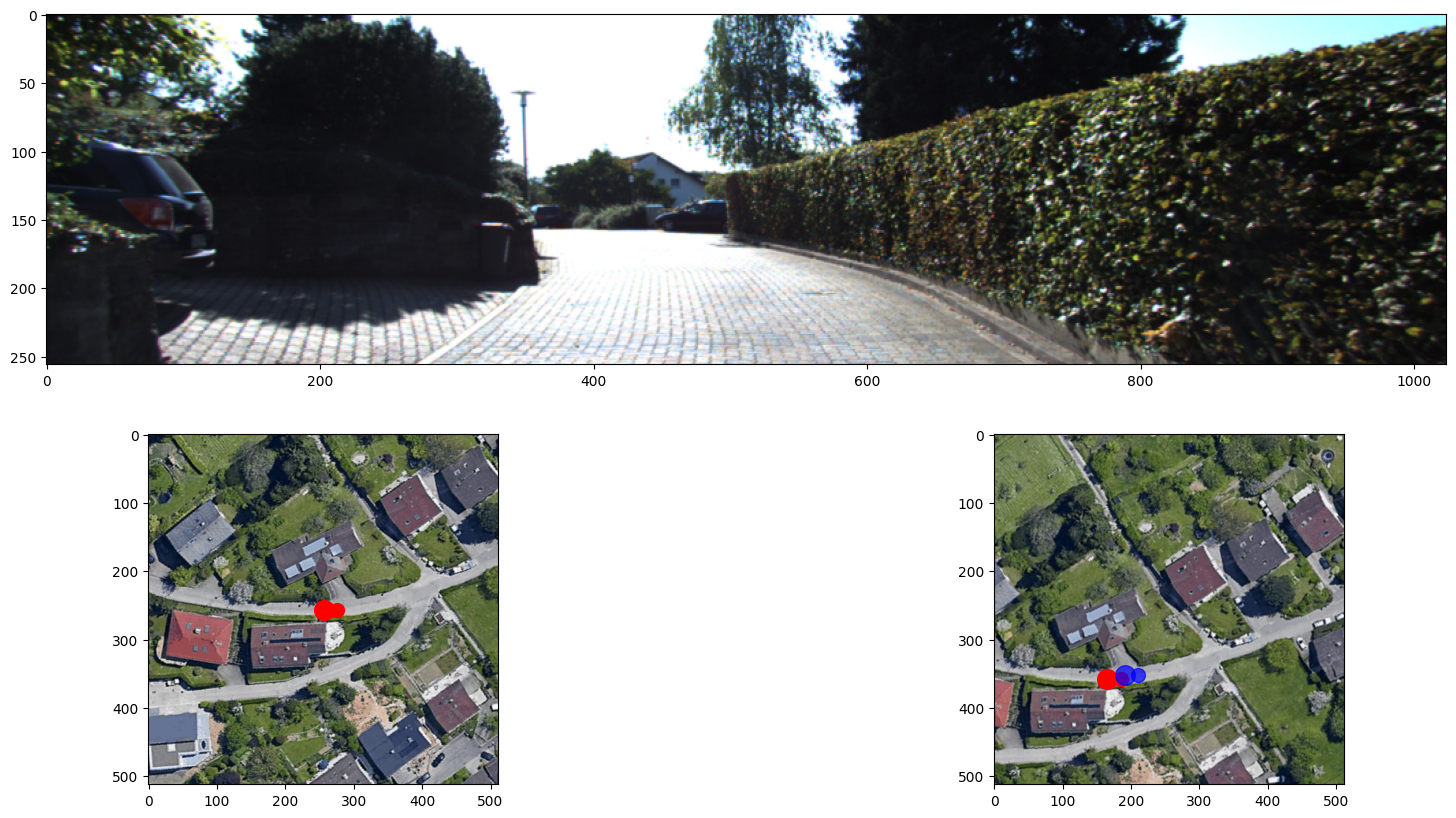

In [5]:
shift_range_lat=20; shift_range_lon=20; rotation_range=10
batch_size = 1


dataset = SatGrdDatasetTest(root = KITTI_dataset_s.root_dir, file=KITTI_dataset_s.test1_file,
                            transform=(KITTI_dataset_s.satmap_transform, KITTI_dataset_s.grdimage_transform),
                            shift_range_lat=args.shift_range_lat,
                            shift_range_lon=args.shift_range_lon,
                            rotation_range=args.rotation_range)



for i in range(10):
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0:2])# This spans all columns in the first row
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    idx = i #24
    data = dataset[idx]
            
    sat_map, left_camera_k, grd_left_imgs, gt_shift_u, gt_shift_v, gt_heading, file_paths, test_data = [item.to(device).unsqueeze(0) if type(item) == torch.Tensor else item for item in data]

    sat_map_center = utils.SatMap_original_sidelength/2
    grd_left_imgs_cpu = grd_left_imgs[0].cpu()
    sat_map_cpu  = sat_map[0].cpu().permute([1,2,0])
    x = gt_shift_u[0].cpu() * shift_range_lon/utils.get_meter_per_pixel()
    y = gt_shift_v[0].cpu() * shift_range_lat/utils.get_meter_per_pixel()
    a = 20
    x_rot = x + a * cos(gt_heading[0].cpu() * rotation_range  * np.pi/180 ) 
    y_rot = y + a * sin(gt_heading[0].cpu() * rotation_range  * np.pi/180 )
    test_data_cpu = test_data[0].cpu().permute([1,2,0])
    grd_left_imgs_cpu = grd_left_imgs[0].cpu().permute([1,2,0])
    gt_shift_u_cpu, gt_shift_v_cpu, gt_heading_cpu = gt_shift_u[0].cpu(), gt_shift_v[0].cpu(), gt_heading[0].cpu()


    ax1.imshow(grd_left_imgs_cpu)
    ax2.imshow(test_data_cpu)
    ax2.scatter(sat_map_center ,sat_map_center, color = 'red', s = 200)
    ax2.scatter(sat_map_center +20,sat_map_center, color = 'red', s=100)


    with torch.no_grad():
        # gt_heading = torch.zeros((3,1), dtype=float).to(device)
        pred_u, pred_v, pred_orien = net.CVattn_rot_corr(sat_map, grd_left_imgs, left_camera_k, gt_heading=gt_heading, mode='test')

    x_pred = pred_u[0].cpu()/utils.get_meter_per_pixel()
    y_pred = pred_v[0].cpu()/utils.get_meter_per_pixel()
    x_rot_pred = x_pred + a * cos(pred_orien[0].cpu() * np.pi/180 )
    y_rot_pred = y_pred + a * sin(pred_orien[0].cpu() * np.pi/180 ) 

    ax3.imshow(sat_map_cpu)
    ax3.scatter(sat_map_center+x, sat_map_center-y, color = 'red', s = 200)
    ax3.scatter(sat_map_center+x_rot,sat_map_center-y_rot, color = 'red', s = 100)

    ax3.imshow(sat_map_cpu)
    ax3.scatter(sat_map_center + x_pred, sat_map_center - y_pred, color = 'blue', s = 200, alpha=0.7)
    ax3.scatter(sat_map_center + x_rot_pred,sat_map_center - y_rot_pred, color = 'blue', s = 100, alpha=0.7)


    # with torch.no_grad():
    #     pred_u, pred_v, pred_orien = net.CVattn_rot_corr(sat_map, grd_left_imgs, left_camera_k, gt_heading=torch.zeros((3,1), dtype=float).to(device), mode='test')
    # x_pred = pred_u[0].cpu()/utils.get_meter_per_pixel()
    # y_pred = pred_v[0].cpu()/utils.get_meter_per_pixel()
    # x_rot_pred = x_pred + a * cos(pred_orien[0].cpu() * np.pi/180 )
    # y_rot_pred = y_pred + a * sin(pred_orien[0].cpu() * np.pi/180 ) 
    # ax3.scatter(sat_map_center + x_pred, sat_map_center - y_pred, color = 'yellow', s = 200, alpha=0.7)
    # ax3.scatter(sat_map_center + x_rot_pred,sat_map_center - y_rot_pred, color = 'yellow', s = 100, alpha=0.7)

    # print(test_data.size)
    print(gt_shift_u[0] * shift_range_lon/utils.get_meter_per_pixel(), gt_shift_v[0] * shift_range_lat/utils.get_meter_per_pixel(), gt_heading[0] * rotation_range)
    print(pred_u[0]/utils.get_meter_per_pixel(), pred_v[0] /utils.get_meter_per_pixel(), pred_orien[0])
    file_paths

    plt.show()
